In [77]:
import tensorflow as tf
import numpy as np 
import matplotlib.pyplot as plt

feature = {
    # model inputs
    "cost_map": gridmap_feature(costmap),
    "init_path": bytes_feature(init_path),
    "feature_vector": bytes_feature(feature_vector),
    "opt_path": bytes_feature(opt_path),
    "car_odo": bytes_feature(car_odo),
    "file_details":string_feature(file_details),
    "unequal_indices":bytes_feature(unequal_indices),
    # model outputs
    "diff_path":bytes_feature(diff_path)
}

In [85]:

def parse_tfrecord_fn_ds(example):

    # Dict of feature and their description
    feature_description = {

        # model inputs
        "cost_map": tf.io.FixedLenFeature([], tf.string),
        "init_path": tf.io.FixedLenFeature([], tf.string),
        "feature_vector": tf.io.FixedLenFeature([], tf.string),
        "opt_path": tf.io.FixedLenFeature([], tf.string),
        "car_odo": tf.io.FixedLenFeature([], tf.string),
        "file_details" : tf.io.FixedLenFeature([],tf.string),
        "unequal_indices":tf.io.FixedLenFeature([],tf.string),
        #model ouput
        "diff_path": tf.io.FixedLenFeature([], tf.string),

    }

    # Parse a single Example proto
    example = tf.io.parse_single_example(example, feature_description)
    return example

    # function to contruct back from tf record example
def prepare_sample(example):
    example["cost_map"] = tf.io.decode_raw(example["cost_map"], out_type=tf.uint8)
    example["cost_map"] = tf.reshape(example["cost_map"],[1536,1536])
    example["cost_map"] = tf.cast(example["cost_map"],dtype=tf.float16)
    example["cost_map"] = example["cost_map"]/255.0
    #print(example["cost_map"])


    example["car_odo"] = tf.io.decode_raw(example["car_odo"], out_type=tf.float32)
    #example["car_odo"] = tf.reshape(example["car_odo"],[1,3])

    example["init_path"] = tf.io.decode_raw(example["init_path"], out_type=tf.float32)
    example["init_path"] = tf.reshape(example["init_path"],[25,2])

    example["opt_path"] = tf.io.decode_raw(example["opt_path"], out_type=tf.float32)
    example["opt_path"] = tf.reshape(example["opt_path"],[25,2])

    example["diff_path"] = tf.io.decode_raw(example["diff_path"], out_type=tf.float32)
    example["diff_path"] = tf.reshape(example["diff_path"],[25,2])

    example["unequal_indices"] = tf.io.decode_raw(example["unequal_indices"], out_type=tf.float32)

    example["feature_vector"] = tf.io.decode_raw(example["feature_vector"],out_type=tf.float32)
    example["feature_vector"] = tf.reshape(example["feature_vector"],[25,1040])


    return example


In [86]:
rec_path = r'D:\tf_records_w_cm_fv_diff\scenario3\2021-06-10_11-20-31\2021-06-10_11-20-32_0_file_02-16.tfrec'


sample_raw_ds = tf.data.TFRecordDataset(rec_path)
#(r"D:\tf_records\scenario1\2021-06-10_08-54-06\2021-06-10_08-54-07_0_file_00-16.tfrec")

parsed_dataset = sample_raw_ds.map(parse_tfrecord_fn_ds).map(prepare_sample)

parsed_dataset.element_spec


{'car_odo': TensorSpec(shape=(None,), dtype=tf.float32, name=None),
 'cost_map': TensorSpec(shape=(1536, 1536), dtype=tf.float16, name=None),
 'diff_path': TensorSpec(shape=(25, 2), dtype=tf.float32, name=None),
 'feature_vector': TensorSpec(shape=(25, 1040), dtype=tf.float32, name=None),
 'file_details': TensorSpec(shape=(), dtype=tf.string, name=None),
 'init_path': TensorSpec(shape=(25, 2), dtype=tf.float32, name=None),
 'opt_path': TensorSpec(shape=(25, 2), dtype=tf.float32, name=None),
 'unequal_indices': TensorSpec(shape=(None,), dtype=tf.float32, name=None)}

In [87]:
def plot_scene(features):    
    grid_map = features["cost_map"].numpy()
    #grid_org = features["grid_org_res"].numpy()
    #left_bnd = features["left_bnd"].numpy()
    #right_bnd = features["right_bnd"].numpy()
    init_path = features["init_path"].numpy()
    opt_path = features["opt_path"].numpy()
    car_odo = features["car_odo"].numpy()

    #print(type(grid_map))
    plt.figure(figsize=(15, 15),dpi=120)
    #ax=fig.add_subplot(1,1,1)

    #res = grid_org[2]
    #plt.plot((left_bnd[:,0],(left_bnd[:,1])),'-.', color='magenta',markersize=0.5, linewidth=0.5)

    plt.plot(init_path[:,0],(init_path[:,1]),'o-', color='lawngreen',markersize=1, linewidth=1)
    plt.plot(opt_path[:,0],(opt_path[:,1]),'--', color='yellow',markersize=1, linewidth=1)

    #plt.plot((right_bnd[:,0],(right_bnd[:,1])), '-.',color='magenta',markersize=0.5, linewidth=0.5)


    plt.plot(car_odo[0],car_odo[1],'r*', color = 'red',markersize=8)


    plt.legend(['gt_init_path', 'gt_opt_path', 'car_centre'], loc='lower left')

    plt.imshow(grid_map.astype(float),origin="lower",cmap='jet')
    plt.colorbar()

    return plt


car_odo: (2,)
diff_path: (25, 2)
feature_vector: (25, 1040)
file_details: ()
file_details: scenario3/2021-06-10_11-20-31/2021-06-10_11-20-32_0_nos125_costmap_init_opt_diff_odo_fv.npz
init_path: (25, 2)
opt_path: (25, 2)
unequal_indices: (18,)


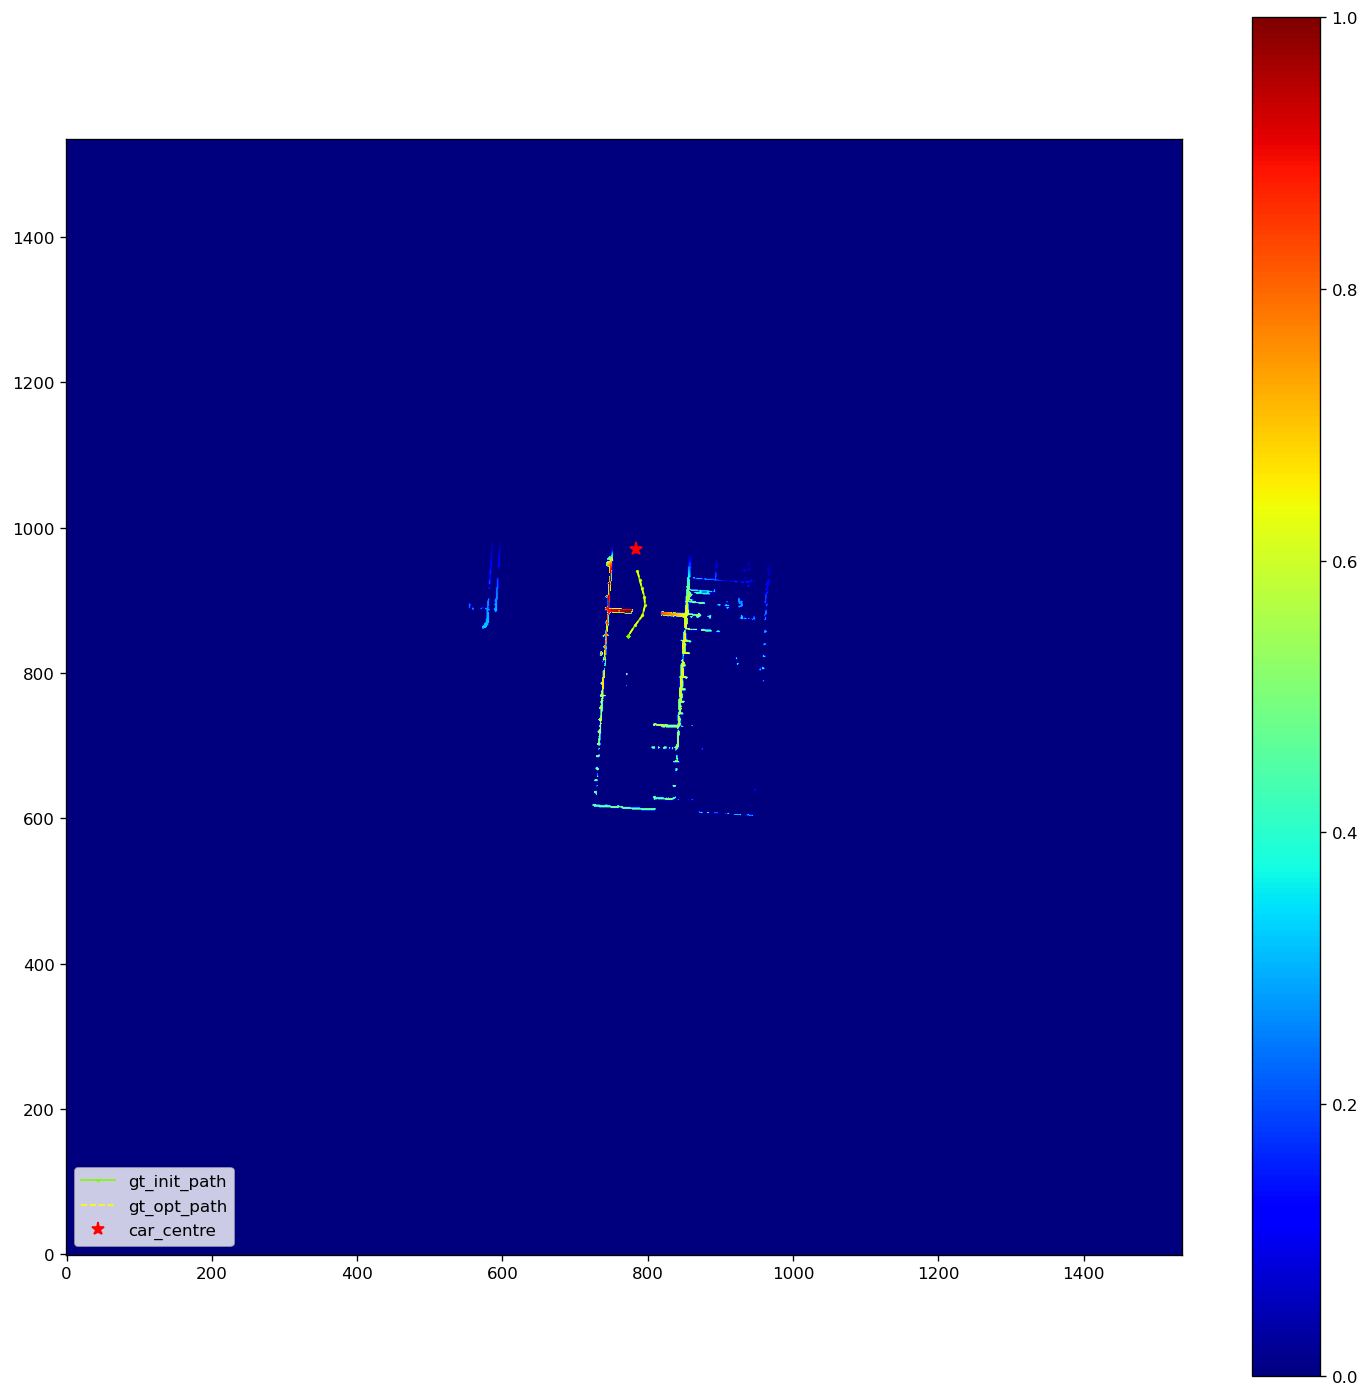

In [97]:
for features in parsed_dataset.skip(12).take(1):
    for key in features.keys():
        if key != "cost_map":
            print(f"{key}: {np.shape(features[key].numpy())}")
        if key in {"file_details"}:
            print(f"{key}: {(features[key].numpy()).decode('utf-8')}")
        #if key=='cost_map':
        #    print(f"{key}: {type(features[key])}")
            #griddat = features[key].numpy()
            #print(key)
            pass
    _ = plot_scene(features=features)